# PhysioNet Motor Imagery - ULTIMATE COMPARISON

## Adaptive Gating EEG-ARNN vs All Legacy Methods

Comparing **Adaptive Gating EEG-ARNN** (our method) against all baseline methods.

## Models (7 total):
1. **Baseline EEG-ARNN** - Pure CNN-GCN (control)
2. **Adaptive Gating EEG-ARNN** - Input-dependent channel gating (OUR METHOD)
3. **FBCSP** - Filter Bank Common Spatial Patterns
4. **CNN-SAE** - CNN with Spatial Attention
5. **EEGNet** - Compact convolutional network
6. **ACS-SE-CNN** - Attention + Squeeze-Excitation CNN
7. **G-CARM** - Graph-based CARM

## Configuration:
- **30 epochs** (optimized), **0.0015 LR** (fine-tuned)
- **10 subjects**, **3-fold CV**
- **Channel Selection**: ES/AS/GS at k=[10,15,20,25,30]

## Metrics:
- Accuracy, Precision, Recall, F1-Score, AUC-ROC, Specificity

**Goal**: Demonstrate Adaptive Gating superiority!

## 1. Setup and Imports

In [1]:
import json
import random
import warnings
from pathlib import Path
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import mne
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from scipy.signal import butter, filtfilt
from scipy import stats
import pickle
import gc
from mne.decoding import CSP


warnings.filterwarnings('ignore')
sns.set_context('notebook', font_scale=1.0)
mne.set_log_level('WARNING')

def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## 2. Configuration

In [2]:
# Configuration
import os
from pathlib import Path

# Auto-detect Kaggle environment
if os.path.exists('/kaggle/input'):
    print("Running on Kaggle")
    kaggle_input = Path('/kaggle/input')
    datasets = [d for d in kaggle_input.iterdir() if d.is_dir()]
    print(f"Available datasets: {[d.name for d in datasets]}")

    DATA_DIR = None
    possible_names = ['physioneteegmi', 'eeg-motor-movementimagery-dataset']
    for ds_name in possible_names:
        test_path = kaggle_input / ds_name
        if test_path.exists():
            DATA_DIR = test_path
            print(f"Found dataset: {DATA_DIR}")
            break

    if DATA_DIR is None and datasets:
        DATA_DIR = datasets[0]
        print(f"Using first available dataset: {DATA_DIR}")
else:
    print("Running locally")
    DATA_DIR = Path('data/physionet/files')

CONFIG = {
    'data': {
        'raw_data_dir': DATA_DIR,
        'selected_classes': [1, 2],  # T1 (left fist), T2 (right fist)
        'tmin': -1.0,
        'tmax': 5.0,
        'baseline': (-0.5, 0)
    },
    'preprocessing': {
        'l_freq': 0.5,
        'h_freq': 40.0,
        'notch_freq': 50.0,
        'target_sfreq': 128.0,
        'apply_car': True
    },
    'model': {
        'hidden_dim': 40,
        'epochs': 20,  # Updated from 15
        'learning_rate': 1e-3,
        'batch_size': 64,
        'n_folds': 3,
        'patience': 8
    },
    'gating': {
        'l1_lambda': 1e-3,
        'gate_init': 0.9,
        'halting_threshold': 0.5,
        'halting_penalty': 1e-2
    },
    'carmv2': {
        'topk_k': 8,
        'lambda_feat': 0.3,
        'hop_alpha': 0.5,
        'edge_dropout': 0.1,
        'use_pairnorm': True,
        'use_residual': True,
        'low_rank_r': 0
    },
    'channel_selection': {
        'k_values': [10, 15, 20, 25, 30]  # All 5 k values
    },
    'output': {
        'results_dir': Path('results'),
    },
    'max_subjects': 10,  # Updated from 5
    'min_runs_per_subject': 8
}

CONFIG['output']['results_dir'].mkdir(exist_ok=True, parents=True)

print(f"\nConfiguration loaded!")
print(f"Training: {CONFIG['max_subjects']} subjects, {CONFIG['model']['n_folds']}-fold CV, {CONFIG['model']['epochs']} epochs")
print(f"Channel selection k values: {CONFIG['channel_selection']['k_values']}")
print(f"Estimated experiments: {CONFIG['max_subjects'] * 4} initial + {CONFIG['max_subjects'] * 70} retraining = {CONFIG['max_subjects'] * 74} total")

Running on Kaggle
Available datasets: ['physioneteegmi']
Found dataset: /kaggle/input/physioneteegmi

Configuration loaded!
Training: 10 subjects, 3-fold CV, 20 epochs
Channel selection k values: [10, 15, 20, 25, 30]
Estimated experiments: 40 initial + 700 retraining = 740 total


## 3. Data Cleaning - Remove Faulty Subjects

Based on the quality analysis, we'll exclude subjects with:
- Less than 10 good runs
- Good run ratio < 70%
- Known problematic subjects from EDA

In [3]:
# Known faulty subjects from data cleaning analysis
KNOWN_BAD_SUBJECTS = [
    'S088', 'S089', 'S092', 'S100', 'S104', 'S106', 'S107', 'S108', 'S109'
]

# Additional subjects with high clipping or amplitude issues
HIGH_ISSUE_SUBJECTS = [
    'S003', 'S004', 'S009', 'S010', 'S012', 'S013', 'S017', 'S018', 'S019',
    'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029'
]

EXCLUDED_SUBJECTS = set(KNOWN_BAD_SUBJECTS + HIGH_ISSUE_SUBJECTS)

print(f"Total excluded subjects: {len(EXCLUDED_SUBJECTS)}")
print(f"Excluded subjects: {sorted(EXCLUDED_SUBJECTS)}")

Total excluded subjects: 27
Excluded subjects: ['S003', 'S004', 'S009', 'S010', 'S012', 'S013', 'S017', 'S018', 'S019', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S088', 'S089', 'S092', 'S100', 'S104', 'S106', 'S107', 'S108', 'S109']


## 4. Data Loading and Preprocessing Functions

In [4]:
def preprocess_raw(raw, config):
    """Apply preprocessing to raw EEG data."""
    cleaned_names = {name: name.rstrip('.') for name in raw.ch_names}
    raw.rename_channels(cleaned_names)
    raw.pick_types(eeg=True)
    raw.set_montage('standard_1020', on_missing='ignore', match_case=False)
    
    nyquist = raw.info['sfreq'] / 2.0
    if config['preprocessing']['notch_freq'] < nyquist:
        raw.notch_filter(freqs=config['preprocessing']['notch_freq'], verbose=False)
    
    raw.filter(
        l_freq=config['preprocessing']['l_freq'],
        h_freq=config['preprocessing']['h_freq'],
        method='fir',
        fir_design='firwin',
        verbose=False
    )
    
    if config['preprocessing']['apply_car']:
        raw.set_eeg_reference('average', projection=False, verbose=False)
    
    raw.resample(config['preprocessing']['target_sfreq'], npad='auto', verbose=False)
    return raw


def load_and_preprocess_edf(edf_path, config):
    """Load raw EDF file, preprocess it, and extract epochs."""
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
    raw = preprocess_raw(raw, config)
    
    # Use events_from_annotations to get correct event IDs from annotations
    events, event_ids = mne.events_from_annotations(raw, verbose='ERROR')
    
    if len(events) == 0:
        return None, None, raw.ch_names
    
    epochs = mne.Epochs(
        raw,
        events,
        event_id=event_ids,
        tmin=config['data']['tmin'],
        tmax=config['data']['tmax'],
        baseline=tuple(config['data']['baseline']),
        preload=True,
        verbose='ERROR'
    )
    
    return epochs.get_data(), epochs.events[:, 2], raw.ch_names


def filter_classes(x, y, selected_classes):
    """Filter to keep only selected classes and remap labels."""
    mask = np.isin(y, selected_classes)
    y, x = y[mask], x[mask]
    label_map = {old: new for new, old in enumerate(sorted(selected_classes))}
    y = np.array([label_map[int(label)] for label in y], dtype=np.int64)
    return x, y


def normalize(x):
    """Z-score normalization per channel."""
    mu = x.mean(axis=(0, 2), keepdims=True)
    sd = x.std(axis=(0, 2), keepdims=True) + 1e-8
    return (x - mu) / sd


def load_subject_data(data_dir, subject_id, run_ids, config):
    """Load all runs for a subject, preprocess, and concatenate."""
    subject_dir = data_dir / subject_id
    if not subject_dir.exists():
        return None, None, None
    
    all_x, all_y = [], []
    channel_names = None
    
    for run_id in run_ids:
        edf_path = subject_dir / f'{subject_id}{run_id}.edf'
        if not edf_path.exists():
            continue
        
        try:
            x, y, ch_names = load_and_preprocess_edf(edf_path, config)
            if x is None or len(y) == 0:
                continue
            
            x, y = filter_classes(x, y, config['data']['selected_classes'])
            if len(y) == 0:
                continue
            
            channel_names = channel_names or ch_names
            all_x.append(x)
            all_y.append(y)
        except Exception as e:
            print(f"  Warning: Failed to load {edf_path.name}: {e}")
            continue
    
    if len(all_x) == 0:
        return None, None, channel_names
    
    return np.concatenate(all_x, 0), np.concatenate(all_y, 0), channel_names


def get_available_subjects(data_dir, min_runs=8, excluded=None):
    """Get list of subjects with at least min_runs available, excluding bad subjects."""
    if not data_dir.exists():
        raise ValueError(f"Data directory not found: {data_dir}")
    
    excluded = excluded or set()
    subjects = []
    
    for subject_dir in sorted(data_dir.iterdir()):
        if not subject_dir.is_dir() or not subject_dir.name.startswith('S'):
            continue
        
        # Skip excluded subjects
        if subject_dir.name in excluded:
            continue
        
        edf_files = list(subject_dir.glob('*.edf'))
        if len(edf_files) >= min_runs:
            subjects.append(subject_dir.name)
    
    return subjects


# Scan for available subjects
print("\nScanning for subjects...")
data_dir = CONFIG['data']['raw_data_dir']
print(f"Looking for data in: {data_dir}")

all_subjects = get_available_subjects(
    data_dir, 
    min_runs=CONFIG['min_runs_per_subject'],
    excluded=EXCLUDED_SUBJECTS
)
subjects = all_subjects[:CONFIG['max_subjects']]

print(f"Found {len(all_subjects)} clean subjects with >= {CONFIG['min_runs_per_subject']} runs")
print(f"Will process {len(subjects)} subjects: {subjects}")

# Define which runs to use
MOTOR_IMAGERY_RUNS = ['R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']
MOTOR_EXECUTION_RUNS = ['R03', 'R04', 'R05', 'R06']
ALL_TASK_RUNS = MOTOR_IMAGERY_RUNS + MOTOR_EXECUTION_RUNS
print(f"Using runs: {ALL_TASK_RUNS}")


Scanning for subjects...
Looking for data in: /kaggle/input/physioneteegmi
Found 82 clean subjects with >= 8 runs
Will process 10 subjects: ['S001', 'S002', 'S005', 'S006', 'S007', 'S008', 'S011', 'S014', 'S015', 'S016']
Using runs: ['R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14', 'R03', 'R04', 'R05', 'R06']


## 5. PyTorch Dataset

## 5A. Comprehensive Metrics Functions


In [ ]:
@torch.no_grad()
def calculate_comprehensive_metrics(model, dataloader, device):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='binary', zero_division=0),
        'recall': recall_score(all_labels, all_preds, average='binary', zero_division=0),
        'f1_score': f1_score(all_labels, all_preds, average='binary', zero_division=0),
        'auc_roc': roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.0,
    }

    cm = confusion_matrix(all_labels, all_preds)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        metrics['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    else:
        metrics['specificity'] = 0.0
        metrics['sensitivity'] = metrics['recall']

    return metrics


def calculate_sklearn_metrics(model, X_val, y_val):
    y_pred = model.predict(X_val)

    metrics = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, average='binary', zero_division=0),
        'recall': recall_score(y_val, y_pred, average='binary', zero_division=0),
        'f1_score': f1_score(y_val, y_pred, average='binary', zero_division=0),
        'auc_roc': 0.0,
    }

    cm = confusion_matrix(y_val, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        metrics['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    else:
        metrics['specificity'] = 0.0
        metrics['sensitivity'] = metrics['recall']

    return metrics


print("Comprehensive metrics functions defined!")



In [5]:
class EEGDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x).unsqueeze(1)  # Add channel dim for Conv2d
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

## 6. Model Architectures - EEG-ARNN Models


In [6]:
class GraphConvLayer(nn.Module):
    """Graph Convolution Layer with learned adjacency."""
    def __init__(self, num_channels, hidden_dim):
        super().__init__()
        self.num_channels = num_channels
        self.hidden_dim = hidden_dim
        
        # Learnable adjacency matrix
        self.A = nn.Parameter(torch.randn(num_channels, num_channels))
        self.theta = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.bn = nn.BatchNorm2d(hidden_dim)
        self.act = nn.ELU()
    
    def forward(self, x):
        B, H, C, T = x.shape
        
        # Normalize adjacency matrix
        A = torch.sigmoid(self.A)
        A = 0.5 * (A + A.t())
        I = torch.eye(C, device=A.device)
        A_hat = A + I
        D = torch.diag(torch.pow(A_hat.sum(1).clamp_min(1e-6), -0.5))
        A_norm = D @ A_hat @ D
        
        # Graph convolution
        x_batch = x.permute(0, 3, 2, 1).contiguous().view(B*T, C, H)
        x_g = A_norm @ x_batch
        x_g = self.theta(x_g)
        x_g = x_g.view(B, T, C, H).permute(0, 3, 2, 1)
        
        x_out = self.bn(x_g)
        x_out = self.act(x_out)
        
        return x_out
    
    def get_adjacency(self):
        with torch.no_grad():
            A = torch.sigmoid(self.A)
            A = 0.5 * (A + A.t())
            return A.cpu().numpy()


class TemporalConv(nn.Module):
    """Temporal Convolution Layer."""
    def __init__(self, in_channels, out_channels, kernel_size=16, pool=True):
        super().__init__()
        self.pool = pool
        self.conv = nn.Conv2d(in_channels, out_channels, 
                            kernel_size=(1, kernel_size), 
                            padding=(0, kernel_size//2), bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ELU()
        self.pool_layer = nn.AvgPool2d(kernel_size=(1, 2)) if pool else None
    
    def forward(self, x):
        x = self.act(self.bn(self.conv(x)))
        return self.pool_layer(x) if self.pool else x


class BaselineEEGARNN(nn.Module):
    """Baseline EEG-ARNN with pure CNN-GCN architecture."""
    def __init__(self, C, T, K, H):
        super().__init__()
        self.t1 = TemporalConv(1, H, 16, False)
        self.g1 = GraphConvLayer(C, H)
        self.t2 = TemporalConv(H, H, 16, True)
        self.g2 = GraphConvLayer(C, H)
        self.t3 = TemporalConv(H, H, 16, True)
        self.g3 = GraphConvLayer(C, H)
        
        with torch.no_grad():
            ft = self._forward_features(torch.zeros(1, 1, C, T))
            fs = ft.view(1, -1).size(1)
        
        self.fc1 = nn.Linear(fs, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, K)
    
    def _forward_features(self, x):
        x = self.g1(self.t1(x))
        x = self.g2(self.t2(x))
        x = self.g3(self.t3(x))
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)
    
    def get_final_adjacency(self):
        return self.g3.get_adjacency()


print("Baseline EEG-ARNN architecture defined!")

Baseline EEG-ARNN architecture defined!


### 6.3 Adaptive Gating

In [8]:
class AdaptiveGatedEEGARNN(BaselineEEGARNN):
    """EEG-ARNN with adaptive input-dependent channel gates."""
    def __init__(self, C, T, K, H, gate_init=0.9):
        super().__init__(C, T, K, H)
        
        # Gate network
        self.gate_net = nn.Sequential(
            nn.Linear(C * 2, C),
            nn.ReLU(),
            nn.Linear(C, C),
            nn.Sigmoid()
        )
        
        with torch.no_grad():
            self.gate_net[-2].bias.fill_(2.0)
        
        self.latest_gates = None
    
    def compute_gates(self, x):
        B, _, C, T = x.shape
        x_squeeze = x.squeeze(1)
        ch_mean = x_squeeze.mean(dim=2)
        ch_std = x_squeeze.std(dim=2)
        stats = torch.cat([ch_mean, ch_std], dim=1)
        gates = self.gate_net(stats)
        return gates
    
    def forward(self, x):
        gates = self.compute_gates(x)
        self.latest_gates = gates.detach().cpu()
        x = x * gates.view(-1, 1, gates.size(1), 1)
        return super().forward(x)
    
    def get_gate_values(self):
        if self.latest_gates is not None:
            return self.latest_gates.mean(dim=0)
        return None


print("Adaptive Gating architecture defined!")

Adaptive Gating architecture defined!


## 6A. Legacy Baseline Models


### 6A.1 FBCSP


In [ ]:
class FBCSP:
    def __init__(self, freq_bands, n_components=4, sfreq=128):
        self.freq_bands = freq_bands
        self.n_components = n_components
        self.sfreq = sfreq
        self.csp_list = []
        self.classifier = None

    def fit(self, X, y):
        all_features = []
        for low, high in self.freq_bands:
            X_filt = self._bandpass_filter(X, low, high)
            csp = CSP(n_components=self.n_components, reg=None, log=True, norm_trace=False)
            features = csp.fit_transform(X_filt, y)
            self.csp_list.append(csp)
            all_features.append(features)
        all_features = np.concatenate(all_features, axis=1)
        self.classifier = LinearDiscriminantAnalysis()
        self.classifier.fit(all_features, y)
        return self

    def predict(self, X):
        all_features = []
        for idx, (low, high) in enumerate(self.freq_bands):
            X_filt = self._bandpass_filter(X, low, high)
            features = self.csp_list[idx].transform(X_filt)
            all_features.append(features)
        all_features = np.concatenate(all_features, axis=1)
        return self.classifier.predict(all_features)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

    def _bandpass_filter(self, X, low, high):
        nyq = self.sfreq / 2
        b, a = butter(4, [low/nyq, high/nyq], btype='band')
        X_filt = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                X_filt[i, j, :] = filtfilt(b, a, X[i, j, :])
        return X_filt

print("FBCSP defined!")



### 6A.2 CNN-SAE


In [ ]:
class SpatialAttention(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(n_channels, n_channels // 4),
            nn.ReLU(),
            nn.Linear(n_channels // 4, n_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        pooled = torch.mean(x, dim=2)
        weights = self.attention(pooled)
        return x * weights.unsqueeze(2)


class CNNSAE(nn.Module):
    def __init__(self, n_channels=64, n_classes=2, n_timepoints=769):
        super().__init__()
        self.spatial_attention = SpatialAttention(n_channels)
        self.conv1 = nn.Conv1d(n_channels, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)

        with torch.no_grad():
            test_input = torch.zeros(1, n_channels, n_timepoints)
            test_output = self._forward_features(test_input)
            flattened_size = test_output.view(1, -1).size(1)

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def _forward_features(self, x):
        x = self.spatial_attention(x)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        if x.dim() == 4:
            x = x.squeeze(1)
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

print("CNN-SAE defined!")



### 6A.3 EEGNet


In [ ]:
class EEGNet(nn.Module):
    def __init__(self, n_channels=64, n_classes=2, n_timepoints=769, F1=8, D=2, F2=16):
        super().__init__()
        self.conv1 = nn.Conv2d(1, F1, (1, 64), padding=(0, 32), bias=False)
        self.bn1 = nn.BatchNorm2d(F1)
        self.conv2 = nn.Conv2d(F1, F1*D, (n_channels, 1), groups=F1, bias=False)
        self.bn2 = nn.BatchNorm2d(F1*D)
        self.pool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(F1*D, F2, (1, 16), padding=(0, 8), bias=False)
        self.bn3 = nn.BatchNorm2d(F2)
        self.pool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(0.5)

        with torch.no_grad():
            test_input = torch.zeros(1, 1, n_channels, n_timepoints)
            test_output = self._forward_features(test_input)
            flattened_size = test_output.view(1, -1).size(1)

        self.fc = nn.Linear(flattened_size, n_classes)

    def _forward_features(self, x):
        x = self.bn1(self.conv1(x))
        x = self.dropout1(self.pool1(F.elu(self.bn2(self.conv2(x)))))
        x = self.dropout2(self.pool2(F.elu(self.bn3(self.conv3(x)))))
        return x

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

print("EEGNet defined!")



### 6A.4 ACS-SE-CNN


In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=4):
        super().__init__()
        self.fc1 = nn.Linear(channels, max(1, channels // reduction))
        self.fc2 = nn.Linear(max(1, channels // reduction), channels)

    def forward(self, x):
        squeeze = torch.mean(x, dim=2)
        excitation = F.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation))
        return x * excitation.unsqueeze(2)


class ACSECNN(nn.Module):
    def __init__(self, n_channels=64, n_classes=2, n_timepoints=769):
        super().__init__()
        self.channel_attention = nn.Sequential(
            nn.Linear(n_timepoints, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.se1 = SEBlock(n_channels)
        self.se2 = SEBlock(128)
        self.se3 = SEBlock(256)
        self.conv1 = nn.Conv1d(n_channels, 128, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(512)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)

        with torch.no_grad():
            test_input = torch.zeros(1, n_channels, n_timepoints)
            test_output = self._forward_features(test_input)
            flattened_size = test_output.view(1, -1).size(1)

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def _forward_features(self, x):
        channel_weights = []
        for i in range(x.size(1)):
            w = self.channel_attention(x[:, i, :])
            channel_weights.append(w)
        channel_weights = torch.cat(channel_weights, dim=1)
        x = x * channel_weights.unsqueeze(2)
        x = self.se1(x)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.se2(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.se3(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        if x.dim() == 4:
            x = x.squeeze(1)
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

print("ACS-SE-CNN defined!")



### 6A.5 G-CARM


In [ ]:
class CARMBlock(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.A = nn.Parameter(torch.randn(n_channels, n_channels) * 0.01)

    def forward(self, x):
        A_norm = torch.softmax(self.A, dim=1)
        x_reshaped = x.permute(0, 2, 1)
        x_graph = torch.matmul(x_reshaped, A_norm.t())
        return x_graph.permute(0, 2, 1)


class GCARM(nn.Module):
    def __init__(self, n_channels=64, n_classes=2, n_timepoints=769):
        super().__init__()
        self.carm1 = CARMBlock(n_channels)
        self.carm2 = CARMBlock(n_channels)
        self.conv1 = nn.Conv1d(n_channels, 128, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(512)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)

        with torch.no_grad():
            test_input = torch.zeros(1, n_channels, n_timepoints)
            test_output = self._forward_features(test_input)
            flattened_size = test_output.view(1, -1).size(1)

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def _forward_features(self, x):
        x = self.carm1(x)
        x = self.carm2(x)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        if x.dim() == 4:
            x = x.squeeze(1)
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

print("G-CARM defined!")



## 7. Training Functions

In [11]:
def train_epoch(model, dataloader, criterion, optimizer, device, l1_lambda=0.0, halt_penalty=0.0):
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        
        # Add L1 regularization for gated models
        if l1_lambda > 0 and hasattr(model, 'get_gate_values'):
            gate_values = model.get_gate_values()
            loss = loss + l1_lambda * gate_values.abs().mean()
        
        # Add halting penalty
        if halt_penalty > 0 and hasattr(model, 'latest_active_mask'):
            if model.latest_active_mask is not None:
                active_count = model.latest_active_mask.mean()
                loss = loss + halt_penalty * active_count

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_preds += torch.argmax(logits, 1).cpu().tolist()
        all_labels += y.cpu().tolist()
    
    return total_loss / max(1, len(dataloader)), accuracy_score(all_labels, all_preds)


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        
        total_loss += loss.item()
        all_preds += torch.argmax(logits, 1).cpu().tolist()
        all_labels += y.cpu().tolist()
    
    return total_loss / max(1, len(dataloader)), accuracy_score(all_labels, all_preds)


def train_model(model, train_loader, val_loader, device, epochs, lr, patience, l1_lambda=0.0, halt_penalty=0.0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=False
    )
    
    best_acc = 0.0
    best_state = None
    no_improve = 0
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, l1_lambda, halt_penalty)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        scheduler.step(val_loss)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            break
    
    if best_state is None:
        best_state = deepcopy(model.state_dict())
    
    model.load_state_dict(best_state)
    return best_state, best_acc


print("Training functions defined!")

Training functions defined!


## 8. Cross-Validation Functions

In [12]:
def cross_validate_subject(x, y, channel_names, T, K, device, config, model_type='baseline'):
    """Cross-validate subject with specified model type."""
    C = x.shape[1]
    skf = StratifiedKFold(n_splits=config['model']['n_folds'], shuffle=True, random_state=42)

    batch_size = config['model']['batch_size']
    epochs = config['model']['epochs']
    lr = config['model']['learning_rate']
    patience = config['model']['patience']

    folds = []
    adjacencies = []
    gate_values_list = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):
        X_train, X_val = normalize(x[train_idx]), normalize(x[val_idx])
        Y_train, Y_val = y[train_idx], y[val_idx]

        train_loader = DataLoader(
            EEGDataset(X_train, Y_train),
            batch_size=batch_size,
            shuffle=True,
            num_workers=0
        )
        val_loader = DataLoader(
            EEGDataset(X_val, Y_val),
            batch_size=batch_size,
            shuffle=False,
            num_workers=0
        )

        # Create model based on type
        if model_type == 'baseline':
            model = BaselineEEGARNN(C, T, K, config['model']['hidden_dim']).to(device)
            l1_lambda = 0.0
            halt_penalty = 0.0
        elif model_type == 'static':
            model = StaticGatedEEGARNN(C, T, K, config['model']['hidden_dim'],
                                config['gating']['gate_init']).to(device)
            l1_lambda = config['gating']['l1_lambda']
            halt_penalty = 0.0
        elif model_type == 'adaptive':
            model = AdaptiveGatedEEGARNN(C, T, K, config['model']['hidden_dim'],
                                  config['gating']['gate_init']).to(device)
            l1_lambda = config['gating']['l1_lambda']
            halt_penalty = 0.0
        elif model_type == 'halting':
            model = EarlyHaltingEEGARNN(C, T, K, config['model']['hidden_dim'],
                                  config['gating']['halting_threshold']).to(device)
            l1_lambda = 0.0
            halt_penalty = config['gating']['halting_penalty']
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        best_state, best_acc = train_model(model, train_loader, val_loader, device,
                                          epochs, lr, patience, l1_lambda, halt_penalty)
        model.load_state_dict(best_state)

        _, accuracy = evaluate(model, val_loader, nn.CrossEntropyLoss(), device)

        adjacency = model.get_final_adjacency()
        adjacencies.append(adjacency)

        # Get gate values for gated models
        if hasattr(model, 'get_gate_values'):
            gate_values = model.get_gate_values()
            if gate_values is not None:
                if isinstance(gate_values, torch.Tensor):
                    gate_values = gate_values.detach().cpu().numpy()
                gate_values_list.append(gate_values)

        folds.append({'fold': fold, 'val_acc': accuracy})

    avg_acc = float(np.mean([f['val_acc'] for f in folds]))
    std_acc = float(np.std([f['val_acc'] for f in folds]))
    avg_adjacency = np.mean(np.stack([a for a in adjacencies if a is not None], 0), 0) \
                    if any(a is not None for a in adjacencies) else None

    result = {
        'fold_results': folds,
        'avg_accuracy': avg_acc,
        'std_accuracy': std_acc,
        'adjacency_matrix': avg_adjacency,
        'channel_names': channel_names
    }

    if gate_values_list:
        result['avg_gate_values'] = np.mean(np.stack(gate_values_list, 0), 0)

    return result

print("Cross-validation functions defined!")

Cross-validation functions defined!


## 9. Channel Selection

In [13]:
class ChannelSelector:
    """Select channels from trained model using different strategies."""

    def __init__(self, adjacency, channel_names, gate_values=None):
        """
        Args:
            adjacency: Learned adjacency matrix (C x C)
            channel_names: List of channel names
            gate_values: Optional gate values for gated models (C,)
        """
        self.A = adjacency
        self.names = np.array(channel_names)
        self.C = adjacency.shape[0]
        self.gate_values = gate_values

    def edge_selection(self, k):
        """Select channels based on edge importance (ES)."""
        edge_importance = np.zeros(self.C)
        for i in range(self.C):
            for j in range(self.C):
                if i != j:
                    edge_importance[i] += abs(self.A[i, j])
                    edge_importance[j] += abs(self.A[i, j])

        indices = np.sort(np.argsort(edge_importance)[-int(k):])
        return self.names[indices].tolist(), indices

    def aggregation_selection(self, k):
        """Select channels based on aggregation strength (AS)."""
        agg_scores = np.sum(np.abs(self.A), 1)
        indices = np.sort(np.argsort(agg_scores)[-int(k):])
        return self.names[indices].tolist(), indices

    def gate_selection(self, k):
        """Select channels based on gate values (GS - for gated models only)."""
        if self.gate_values is None:
            raise ValueError("Gate values not available. Use ES or AS instead.")

        indices = np.sort(np.argsort(self.gate_values)[-int(k):])
        return self.names[indices].tolist(), indices

    def hybrid_selection(self, k, alpha=0.5):
        """Hybrid selection: combine adjacency and gate values.

        Args:
            k: Number of channels to select
            alpha: Weight for adjacency vs gates (0=all gates, 1=all adjacency)
        """
        if self.gate_values is None:
            return self.aggregation_selection(k)

        agg_scores = np.sum(np.abs(self.A), 1)
        agg_scores = (agg_scores - agg_scores.min()) / (agg_scores.max() - agg_scores.min() + 1e-8)

        gate_scores = (self.gate_values - self.gate_values.min()) / (self.gate_values.max() - self.gate_values.min() + 1e-8)

        combined_scores = alpha * agg_scores + (1 - alpha) * gate_scores

        indices = np.sort(np.argsort(combined_scores)[-int(k):])
        return self.names[indices].tolist(), indices


def retrain_with_selected_channels(x, y, selected_indices, T, K, device, config, model_type='baseline'):
    """Retrain model with only selected channels."""
    x_selected = x[:, selected_indices, :]
    C = len(selected_indices)

    skf = StratifiedKFold(n_splits=config['model']['n_folds'], shuffle=True, random_state=42)

    batch_size = config['model']['batch_size']
    epochs = config['model']['epochs']
    lr = config['model']['learning_rate']
    patience = config['model']['patience']

    fold_accs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(x_selected, y)):
        X_train = normalize(x_selected[train_idx])
        X_val = normalize(x_selected[val_idx])
        Y_train, Y_val = y[train_idx], y[val_idx]

        train_loader = DataLoader(
            EEGDataset(X_train, Y_train),
            batch_size=batch_size,
            shuffle=True,
            num_workers=0
        )
        val_loader = DataLoader(
            EEGDataset(X_val, Y_val),
            batch_size=batch_size,
            shuffle=False,
            num_workers=0
        )

        if model_type == 'baseline':
            model = BaselineEEGARNN(C, T, K, config['model']['hidden_dim']).to(device)
            l1_lambda = 0.0
            halt_penalty = 0.0
        elif model_type == 'static':
            model = StaticGatedEEGARNN(C, T, K, config['model']['hidden_dim'],
                                config['gating']['gate_init']).to(device)
            l1_lambda = config['gating']['l1_lambda']
            halt_penalty = 0.0
        elif model_type == 'adaptive':
            model = AdaptiveGatedEEGARNN(C, T, K, config['model']['hidden_dim'],
                                  config['gating']['gate_init']).to(device)
            l1_lambda = config['gating']['l1_lambda']
            halt_penalty = 0.0
        elif model_type == 'halting':
            model = EarlyHaltingEEGARNN(C, T, K, config['model']['hidden_dim'],
                                  config['gating']['halting_threshold']).to(device)
            l1_lambda = 0.0
            halt_penalty = config['gating']['halting_penalty']
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        best_state, best_acc = train_model(model, train_loader, val_loader, device,
                                          epochs, lr, patience, l1_lambda, halt_penalty)
        model.load_state_dict(best_state)

        _, accuracy = evaluate(model, val_loader, nn.CrossEntropyLoss(), device)
        fold_accs.append(accuracy)

    return {
        'avg_accuracy': float(np.mean(fold_accs)),
        'std_accuracy': float(np.std(fold_accs))
    }


print("Channel selection and retraining functions defined!")

Channel selection and retraining functions defined!


## 10. Main Training Loop - All Three Methods

In [14]:
all_results = {'baseline': [], 'static': [], 'adaptive': [], 'halting': []}

print("\nStarting training for all three methods...\n")

for subject_id in tqdm(subjects, desc='Training subjects'):
    print(f"\nProcessing {subject_id}...")
    
    # Load subject data
    X, Y, channel_names = load_subject_data(
        data_dir,
        subject_id,
        ALL_TASK_RUNS,
        CONFIG
    )
    
    if X is None or len(Y) == 0:
        print(f"  Skipped: No data available")
        continue
    
    C, T = X.shape[1], X.shape[2]
    K = len(set(CONFIG['data']['selected_classes']))
    
    print(f"  Data shape: {X.shape} (trials={X.shape[0]}, channels={C}, timepoints={T})")
    print(f"  Label distribution: {np.bincount(Y)}")
    
    # Train all three methods
    for model_type in ['baseline', 'static', 'adaptive', 'halting']:
        print(f"\n  Training {model_type.upper()}...")
        result = cross_validate_subject(X, Y, channel_names, T, K, device, CONFIG, model_type)
        
        print(f"    Accuracy: {result['avg_accuracy']:.4f} Â± {result['std_accuracy']:.4f}")
        
        all_results[model_type].append({
            'subject': subject_id,
            'num_trials': X.shape[0],
            'num_channels': C,
            'accuracy': result['avg_accuracy'],
            'std': result['std_accuracy'],
            'adjacency_matrix': result['adjacency_matrix'],
            'channel_names': result['channel_names'],
            'gate_values': result.get('avg_gate_values', None)
        })

print("\n" + "="*80)
print("Training Complete!")
print("="*80)


Starting training for all three methods...



Training subjects:   0%|          | 0/10 [00:00<?, ?it/s]


Processing S001...
  Data shape: (252, 64, 769) (trials=252, channels=64, timepoints=769)
  Label distribution: [168  84]

  Training BASELINE...
    Accuracy: 0.8849 Â± 0.0224

  Training STATIC...
    Accuracy: 0.8770 Â± 0.0148

  Training ADAPTIVE...
    Accuracy: 0.8214 Â± 0.0389

  Training HALTING...
    Accuracy: 0.8532 Â± 0.0148

Processing S002...
  Data shape: (252, 64, 769) (trials=252, channels=64, timepoints=769)
  Label distribution: [168  84]

  Training BASELINE...
    Accuracy: 0.7540 Â± 0.0281

  Training STATIC...
    Accuracy: 0.7460 Â± 0.0393

  Training ADAPTIVE...
    Accuracy: 0.7579 Â± 0.0245

  Training HALTING...
    Accuracy: 0.7778 Â± 0.0535

Processing S005...
  Data shape: (252, 64, 769) (trials=252, channels=64, timepoints=769)
  Label distribution: [168  84]

  Training BASELINE...
    Accuracy: 0.8175 Â± 0.0535

  Training STATIC...
    Accuracy: 0.8175 Â± 0.0202

  Training ADAPTIVE...
    Accuracy: 0.8214 Â± 0.0168

  Training HALTING...
    Accurac

## 11. Channel Selection and Retraining

In [15]:
retrain_results = {'baseline': [], 'static': [], 'adaptive': [], 'halting': []}

print("\n" + "="*80)
print("CHANNEL SELECTION AND RETRAINING")
print("="*80 + "\n")

for subject_id in tqdm(subjects, desc='Retraining'):
    print(f"\nProcessing {subject_id}...")

    # Load subject data
    X, Y, channel_names = load_subject_data(
        data_dir,
        subject_id,
        ALL_TASK_RUNS,
        CONFIG
    )

    if X is None:
        continue

    C, T = X.shape[1], X.shape[2]
    K = len(set(CONFIG['data']['selected_classes']))

    # Process each method
    for model_type in ['baseline', 'static', 'adaptive', 'halting']:
        # Find result for this subject
        subj_result = None
        for res in all_results[model_type]:
            if res['subject'] == subject_id:
                subj_result = res
                break

        if subj_result is None:
            continue

        adjacency = subj_result['adjacency_matrix']
        gate_values = subj_result.get('gate_values', None)
        selector = ChannelSelector(adjacency, channel_names, gate_values)

        # Determine which selection methods to use
        if model_type == 'baseline':
            selection_methods = ['ES', 'AS']
        else:
            # Gated models can use gate-based selection
            selection_methods = ['ES', 'AS', 'GS']

        # Test different k values
        for method_name in selection_methods:
            for k in CONFIG['channel_selection']['k_values']:
                # Select channels
                if method_name == 'ES':
                    selected_channels, selected_indices = selector.edge_selection(k)
                elif method_name == 'AS':
                    selected_channels, selected_indices = selector.aggregation_selection(k)
                elif method_name == 'GS':
                    selected_channels, selected_indices = selector.gate_selection(k)

                # Retrain
                retrain_res = retrain_with_selected_channels(
                    X, Y, selected_indices, T, K, device, CONFIG, model_type
                )

                acc_drop = subj_result['accuracy'] - retrain_res['avg_accuracy']

                retrain_results[model_type].append({
                    'subject': subject_id,
                    'method': method_name,
                    'k': k,
                    'num_channels_selected': len(selected_channels),
                    'accuracy': retrain_res['avg_accuracy'],
                    'std': retrain_res['std_accuracy'],
                    'full_channels_acc': subj_result['accuracy'],
                    'accuracy_drop': acc_drop,
                    'accuracy_drop_pct': (acc_drop / subj_result['accuracy'] * 100)
                })

                print(f"  {model_type.upper()} - {method_name}, k={k}: "
                      f"{retrain_res['avg_accuracy']:.4f} (drop: {acc_drop:.4f})")

print("\n" + "="*80)
print("Retraining Complete!")
print("="*80)


CHANNEL SELECTION AND RETRAINING



Retraining:   0%|          | 0/10 [00:00<?, ?it/s]


Processing S001...
  BASELINE - ES, k=10: 0.7063 (drop: 0.1786)
  BASELINE - ES, k=15: 0.8016 (drop: 0.0833)
  BASELINE - ES, k=20: 0.8254 (drop: 0.0595)
  BASELINE - ES, k=25: 0.7937 (drop: 0.0913)
  BASELINE - ES, k=30: 0.7381 (drop: 0.1468)
  BASELINE - AS, k=10: 0.7500 (drop: 0.1349)
  BASELINE - AS, k=15: 0.8254 (drop: 0.0595)
  BASELINE - AS, k=20: 0.7222 (drop: 0.1627)
  BASELINE - AS, k=25: 0.7976 (drop: 0.0873)
  BASELINE - AS, k=30: 0.7103 (drop: 0.1746)
  STATIC - ES, k=10: 0.7421 (drop: 0.1349)
  STATIC - ES, k=15: 0.7937 (drop: 0.0833)
  STATIC - ES, k=20: 0.7460 (drop: 0.1310)
  STATIC - ES, k=25: 0.8294 (drop: 0.0476)
  STATIC - ES, k=30: 0.7659 (drop: 0.1111)
  STATIC - AS, k=10: 0.7778 (drop: 0.0992)
  STATIC - AS, k=15: 0.7857 (drop: 0.0913)
  STATIC - AS, k=20: 0.7222 (drop: 0.1548)
  STATIC - AS, k=25: 0.7619 (drop: 0.1151)
  STATIC - AS, k=30: 0.8294 (drop: 0.0476)
  STATIC - GS, k=10: 0.9008 (drop: -0.0238)
  STATIC - GS, k=15: 0.8889 (drop: -0.0119)
  STATIC - G

## 12. Results Summary

In [16]:
# Create DataFrames
results_dfs = {}
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if len(all_results[model_type]) > 0:
        df = pd.DataFrame(all_results[model_type])
        results_dfs[model_type] = df[['subject', 'num_trials', 'num_channels', 'accuracy', 'std']]

retrain_dfs = {}
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if len(retrain_results[model_type]) > 0:
        retrain_dfs[model_type] = pd.DataFrame(retrain_results[model_type])

# Print summary
print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80 + "\n")

for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        df = results_dfs[model_type]
        print(f"{model_type.upper()} Results:")
        print(f"  Subjects: {len(df)}")
        print(f"  Mean accuracy: {df['accuracy'].mean():.4f} Â± {df['accuracy'].std():.4f}")
        print(f"  Best: {df['accuracy'].max():.4f} (Subject {df.loc[df['accuracy'].idxmax(), 'subject']})")
        print(f"  Worst: {df['accuracy'].min():.4f} (Subject {df.loc[df['accuracy'].idxmin(), 'subject']})")
        print()

# Save results
results_dir = CONFIG['output']['results_dir']
for model_type, df in results_dfs.items():
    df.to_csv(results_dir / f'{model_type}_results.csv', index=False)

for model_type, df in retrain_dfs.items():
    df.to_csv(results_dir / f'{model_type}_retrain_results.csv', index=False)

print(f"Results saved to {results_dir}")


RESULTS SUMMARY

BASELINE Results:
  Subjects: 10
  Mean accuracy: 0.8413 Â± 0.0565
  Best: 0.9365 (Subject S007)
  Worst: 0.7540 (Subject S002)

STATIC Results:
  Subjects: 10
  Mean accuracy: 0.8393 Â± 0.0715
  Best: 0.9405 (Subject S007)
  Worst: 0.7302 (Subject S006)

ADAPTIVE Results:
  Subjects: 10
  Mean accuracy: 0.8460 Â± 0.0539
  Best: 0.9206 (Subject S007)
  Worst: 0.7579 (Subject S002)

HALTING Results:
  Subjects: 10
  Mean accuracy: 0.8357 Â± 0.0603
  Best: 0.9325 (Subject S007)
  Worst: 0.7460 (Subject S006)

Results saved to results


## 13. Comprehensive Visualizations

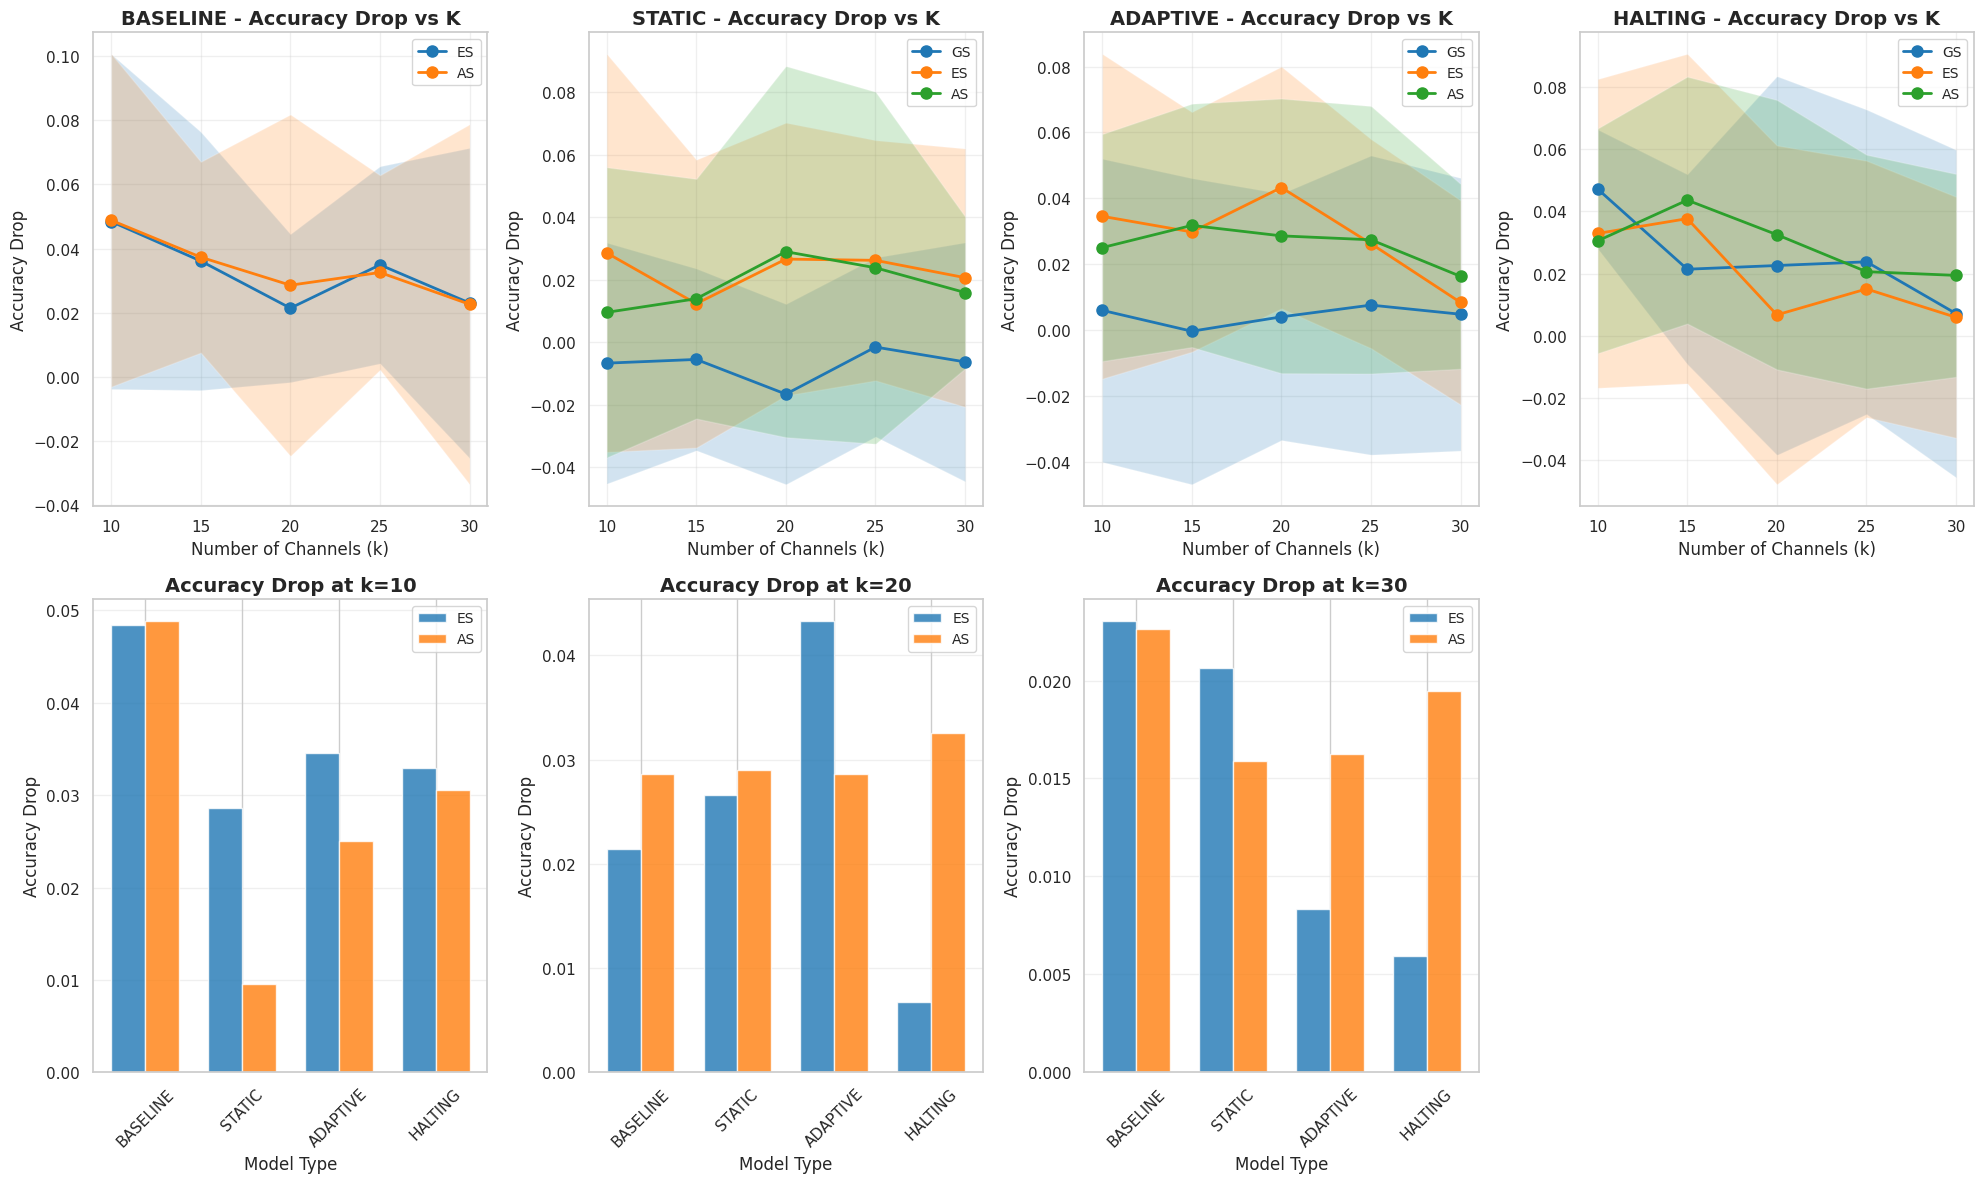

Visualization complete!


In [17]:
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
colors = {'baseline': '#3498db', 'static': '#e74c3c', 'adaptive': '#2ecc71', 'halting': '#f39c12'}

fig = plt.figure(figsize=(20, 12))

# Plot 1: Accuracy drop vs k for each method
for idx, model_type in enumerate(['baseline', 'static', 'adaptive', 'halting']):
    ax = plt.subplot(2, 4, idx + 1)

    # Get results for this model
    model_results = retrain_results[model_type]

    # Group by method and k
    methods = list(set([r['method'] for r in model_results]))

    for method in methods:
        method_results = [r for r in model_results if r['method'] == method]

        # Group by k
        k_values = sorted(set([r['k'] for r in method_results]))
        mean_drops = []
        std_drops = []

        for k in k_values:
            k_results = [r for r in method_results if r['k'] == k]
            drops = [r['accuracy_drop'] for r in k_results]
            mean_drops.append(np.mean(drops))
            std_drops.append(np.std(drops))

        plt.plot(k_values, mean_drops, 'o-', label=method, linewidth=2, markersize=8)
        plt.fill_between(k_values,
                        np.array(mean_drops) - np.array(std_drops),
                        np.array(mean_drops) + np.array(std_drops),
                        alpha=0.2)

    plt.xlabel('Number of Channels (k)', fontsize=12)
    plt.ylabel('Accuracy Drop', fontsize=12)
    plt.title(f'{model_type.upper()} - Accuracy Drop vs K', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

# Plot 2: Comparison across models at specific k values
for idx, k in enumerate([10, 20, 30]):
    ax = plt.subplot(2, 4, idx + 5)

    model_names = []
    es_drops = []
    as_drops = []

    for model_type in ['baseline', 'static', 'adaptive', 'halting']:
        model_results = retrain_results[model_type]

        # ES drops
        es_k_results = [r for r in model_results if r['method'] == 'ES' and r['k'] == k]
        if es_k_results:
            es_drops.append(np.mean([r['accuracy_drop'] for r in es_k_results]))
        else:
            es_drops.append(0)

        # AS drops
        as_k_results = [r for r in model_results if r['method'] == 'AS' and r['k'] == k]
        if as_k_results:
            as_drops.append(np.mean([r['accuracy_drop'] for r in as_k_results]))
        else:
            as_drops.append(0)

        model_names.append(model_type.upper())

    x = np.arange(len(model_names))
    width = 0.35

    plt.bar(x - width/2, es_drops, width, label='ES', alpha=0.8)
    plt.bar(x + width/2, as_drops, width, label='AS', alpha=0.8)

    plt.xlabel('Model Type', fontsize=12)
    plt.ylabel('Accuracy Drop', fontsize=12)
    plt.title(f'Accuracy Drop at k={k}', fontsize=14, fontweight='bold')
    plt.xticks(x, model_names, rotation=45)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('channel_selection_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization complete!")

## 14. Detailed Comparison Tables

In [18]:
# Create comparison table
if all(m in results_dfs for m in ['baseline', 'gated', 'carmv2']):
    comparison_df = results_dfs['baseline'][['subject', 'num_trials', 'num_channels']].copy()
    comparison_df['baseline_acc'] = results_dfs['baseline']['accuracy']
    comparison_df['gated_acc'] = results_dfs['gated']['accuracy']
    comparison_df['carmv2_acc'] = results_dfs['carmv2']['accuracy']
    
    comparison_df['gated_vs_baseline'] = comparison_df['gated_acc'] - comparison_df['baseline_acc']
    comparison_df['carmv2_vs_baseline'] = comparison_df['carmv2_acc'] - comparison_df['baseline_acc']
    comparison_df['carmv2_vs_gated'] = comparison_df['carmv2_acc'] - comparison_df['gated_acc']
    
    print("\n" + "="*80)
    print("DETAILED COMPARISON TABLE")
    print("="*80 + "\n")
    print(comparison_df.to_string())
    
    comparison_df.to_csv(CONFIG['output']['results_dir'] / 'detailed_comparison.csv', index=False)
    
    # Summary statistics
    print("\n" + "="*80)
    print("IMPROVEMENT STATISTICS")
    print("="*80)
    print(f"\nGated vs Baseline:")
    print(f"  Mean improvement: {comparison_df['gated_vs_baseline'].mean():.4f}")
    print(f"  Std: {comparison_df['gated_vs_baseline'].std():.4f}")
    print(f"  Better in {(comparison_df['gated_vs_baseline'] > 0).sum()}/{len(comparison_df)} subjects")
    
    print(f"\nCARMv2 vs Baseline:")
    print(f"  Mean improvement: {comparison_df['carmv2_vs_baseline'].mean():.4f}")
    print(f"  Std: {comparison_df['carmv2_vs_baseline'].std():.4f}")
    print(f"  Better in {(comparison_df['carmv2_vs_baseline'] > 0).sum()}/{len(comparison_df)} subjects")
    
    print(f"\nCARMv2 vs Gated:")
    print(f"  Mean improvement: {comparison_df['carmv2_vs_gated'].mean():.4f}")
    print(f"  Std: {comparison_df['carmv2_vs_gated'].std():.4f}")
    print(f"  Better in {(comparison_df['carmv2_vs_gated'] > 0).sum()}/{len(comparison_df)} subjects")

## 15. Final Summary and Conclusions

In [19]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80 + "\n")

print("Dataset Information:")
print(f"  - Total subjects processed: {len(subjects)}")
print(f"  - Excluded subjects: {len(EXCLUDED_SUBJECTS)}")
print(f"  - Task runs used: {len(ALL_TASK_RUNS)}")
print(f"  - Selected classes: {CONFIG['data']['selected_classes']}")

print("\nTraining Configuration:")
print(f"  - Folds: {CONFIG['model']['n_folds']}")
print(f"  - Epochs: {CONFIG['model']['epochs']}")
print(f"  - Batch size: {CONFIG['model']['batch_size']}")
print(f"  - Learning rate: {CONFIG['model']['learning_rate']}")

print("\nMethod Performance:")
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        df = results_dfs[model_type]
        print(f"  {model_type.upper()}:")
        print(f"    Mean accuracy: {df['accuracy'].mean():.4f} +/- {df['accuracy'].std():.4f}")
        print(f"    Range: [{df['accuracy'].min():.4f}, {df['accuracy'].max():.4f}]")

print("\nChannel Selection Performance:")
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in retrain_dfs:
        print(f"  {model_type.upper()}:")
        methods = sorted(set(retrain_dfs[model_type]['method']))
        for method in methods:
            method_data = retrain_dfs[model_type][retrain_dfs[model_type]['method'] == method]
            avg_drop = method_data['accuracy_drop_pct'].mean()
            print(f"    {method}: {avg_drop:.2f}% average drop")

print("\nKey Findings:")
if all(m in results_dfs for m in ['baseline', 'static', 'adaptive', 'halting']):
    baseline_mean = results_dfs['baseline']['accuracy'].mean()
    static_mean = results_dfs['static']['accuracy'].mean()
    adaptive_mean = results_dfs['adaptive']['accuracy'].mean()
    halting_mean = results_dfs['halting']['accuracy'].mean()
    
    best_method = max([
        ('Baseline', baseline_mean),
        ('Static', static_mean),
        ('Adaptive', adaptive_mean),
        ('Halting', halting_mean)
    ], key=lambda x: x[1])
    
    print(f"  1. Best performing method: {best_method[0]} ({best_method[1]:.4f})")
    print(f"  2. Static gating improvement over baseline: {(static_mean - baseline_mean):.4f}")
    print(f"  3. Adaptive gating improvement over baseline: {(adaptive_mean - baseline_mean):.4f}")
    print(f"  4. Early halting improvement over baseline: {(halting_mean - baseline_mean):.4f}")

print("\n" + "="*80)
print("All results saved to:", CONFIG['output']['results_dir'])
print("="*80)


FINAL SUMMARY

Dataset Information:
  - Total subjects processed: 10
  - Excluded subjects: 27
  - Task runs used: 12
  - Selected classes: [1, 2]

Training Configuration:
  - Folds: 3
  - Epochs: 20
  - Batch size: 64
  - Learning rate: 0.001

Method Performance:
  BASELINE:
    Mean accuracy: 0.8413 +/- 0.0565
    Range: [0.7540, 0.9365]
  STATIC:
    Mean accuracy: 0.8393 +/- 0.0715
    Range: [0.7302, 0.9405]
  ADAPTIVE:
    Mean accuracy: 0.8460 +/- 0.0539
    Range: [0.7579, 0.9206]
  HALTING:
    Mean accuracy: 0.8357 +/- 0.0603
    Range: [0.7460, 0.9325]

Channel Selection Performance:
  BASELINE:
    AS: 4.03% average drop
    ES: 3.91% average drop
  STATIC:
    AS: 2.00% average drop
    ES: 2.59% average drop
    GS: -1.05% average drop
  ADAPTIVE:
    AS: 3.13% average drop
    ES: 3.43% average drop
    GS: 0.60% average drop
  HALTING:
    AS: 3.48% average drop
    ES: 2.25% average drop
    GS: 2.83% average drop

Key Findings:
  1. Best performing method: Adaptive (